<a href="https://colab.research.google.com/github/sajad95/Heat/blob/main/FastCodeImpactofweatherXGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Let's do it :)

# installing librarires
!pip install xgboost
!pip install pandas --quiet
!pip install scikit-learn --upgrade --quiet

# importing libraries
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mounting google drive and uploading the data
drive.mount('/content/saj')
raw_df = pd.read_csv('/content/saj/MyDrive/Kavgic/AllFeaturesInAllyears2.csv')
TMY_df = pd.read_csv('/content/saj/MyDrive/Kavgic/TW.csv')

#remove extra spaces using strip
raw_df['Direct Normal Radiation']=pd.to_numeric(raw_df['Direct Normal Radiation'].astype(str).str.strip())
raw_df['Diffuse Horizontal Radiation']=pd.to_numeric(raw_df['Diffuse Horizontal Radiation'].astype(str).str.strip())

TMY_df['Direct Normal Radiation']=pd.to_numeric(TMY_df['Direct Normal Radiation'].astype(str).str.strip())
TMY_df['Diffuse Horizontal Radiation']=pd.to_numeric(TMY_df['Diffuse Horizontal Radiation'].astype(str).str.strip())
#removing extra spaces in name of the columns 
raw_df.columns = [col.strip() for col in raw_df.columns]
TMY_df.columns = [col.strip() for col in TMY_df.columns]

#removing every rows that has nan values 
raw_df.dropna(subset=['Dry Bulb Temperature','Wind Direction','Direct Normal Radiation','Diffuse Horizontal Radiation'], inplace =True)
TMY_df.dropna(subset=['Dry Bulb Temperature','Wind Direction','Direct Normal Radiation','Diffuse Horizontal Radiation'], inplace =True)

##Impact of weather data on energy demand


Goal is to find the best ways for predicting energy demand in 2019 and compare it with the doe model.
scenarios:
1.   **Training the model with data from 2011 to 2017**

*   predicting energy demand for 2019 when the TW is used ( used both TW files) and comapre it with 2018.  if I want to predict energy demand of 2019 wihout having any data, is it better to use TW or use weather data for previous years. If I want to use data belonged to previous years which year can prdict it better.
*   Effect of number of years on accuracy
*   Finding the accuarcy of model in max and min
*   See the accuaracy of the model on design days



2.   **Improving the accuracy of the model in mins and maxes**

*   Training the Heating and Cooling with deata belonged to cold and warm days
*   Training the data with two TW files
*   Testing the Data of a hot place for cooling
*   Removing columns maybe removin some columns decrease the r2 but it might increase the robutensess of model in predicting min and max
*   Effect of energy unit on result of prediction j vs kj vs Mj 












## predicting energy demand for 2019


* Goal is to find the accuary of he model
* How well TW can predict 2019 
* How well TW can predict 2018 



# Heating ( Electricity)

In [ ]:
raw_df.columns

Get the index of coloumns

In [4]:
raw_df.columns.get_loc('Fans')

38

In [73]:
#Remving columns by their index
## Actua weather data file 
raw_df3=raw_df.drop(raw_df.columns[[1,6,7,15,16,20,21,22,23,24,25,26,27,28,29,34,35,37,38]], axis=1)
## Typical weather data file 
TMY_df3=TMY_df.drop(TMY_df.columns[[1,6,7,15,16,20,21,22,23,24,25,26,27,28,29,34,35,37,38]], axis=1)

In [6]:
pd.set_option('max_columns', None)

In [74]:
raw_df3.insert(0, 'Heating', raw_df3.pop('Heating'))
TMY_df3.insert(0, 'Heating', TMY_df3.pop('Heating'))
raw_df3

,Heating,Date,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Speed,Total Sky Cover,Opaque Sky Cover,People Total Heating Energy,Total Zone Infiltration Sensible Heat Gain Energy,Averge Zones temp,ATTIC:Zone Air Temperature
0,900000.0,1/1/2010,-21.6,-25.4,71.0,100230.0000,177.240384,0,0.0,0.0,0,0,0,9.0,0,8,0.0,4476693.0,13.00748,-28.1504
1,900000.0,1/1/2010,-22.5,-26.0,73.0,100310.0000,174.261326,0,0.0,0.0,0,0,0,11.0,6,8,0.0,3768383.0,12.54072,-25.8800
2,900000.0,1/1/2010,-23.8,-27.5,71.0,100390.0000,157.302450,0,0.0,0.0,0,0,0,13.0,4,1,0.0,1650617.0,11.80668,-24.9026
3,900000.0,1/1/2010,-24.6,-28.1,73.0,100510.0000,166.944016,0,0.0,0.0,0,0,0,11.0,0,8,0.0,1148430.0,11.46979,-25.4089
4,900000.0,1/1/2010,-25.6,-29.1,72.0,100610.0000,163.542481,0,0.0,0.0,0,0,0,11.0,4,8,0.0,821679.4,11.56382,-26.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,11735676.0,12/31/2019,-10.4,-12.9,82.0,97240.0000,222.143953,0,0.0,0.0,0,0,0,9.0,8,8,0.0,1985548.0,15.65689,-12.4567
87596,12807904.0,12/31/2019,-11.0,-12.9,85.0,98778.4745,220.120643,0,0.0,0.0,0,0,0,10.0,0,8,0.0,1573438.0,15.71235,-12.4324
87597,11698992.0,12/31/2019,-10.6,-13.1,82.0,97020.0000,221.294437,0,0.0,0.0,0,0,0,9.0,3,8,0.0,1700574.0,15.59203,-12.5909
87598,12792717.0,12/31/2019,-10.4,-13.2,80.0,96900.0000,221.882804,0,0.0,0.0,0,0,0,8.0,1,8,0.0,1911364.0,15.69048,-12.5501


In [ ]:
#raw_df3=raw_df3[raw_df3.columns.difference([1,2,3])]
#raw_df3
# All coloumns except one
#raw_df3=raw_df3.loc[:, raw_df3.columns != 'Zenith Luminance']

In [75]:
##spliting data  
year = pd.to_datetime(raw_df3.Date).dt.year
train_df = raw_df3[year < 2017]
val_df = raw_df3[year == 2017]
test_df = raw_df3[ year == 2019]

In [76]:
## specifying input and target in  Actua weather data file
input_cols = (train_df.columns)[2:]
target_col = 'Heating'
## specifying input and target in Typical weather data file
input_cols_TMY2 = (TMY_df3.columns)[2:]
target_col_TMY2 = 'Heating'

In [10]:
target_col

'Heating'

In [11]:
input_cols

Index(['Dry Bulb Temperature', 'Dew Point Temperature', 'Relative Humidity',
       'Atmospheric Pressure',
       'Horizontal Infrared Radiation Intensity from Sky',
       'Global Horizontal Radiation', 'Direct Normal Radiation',
       'Diffuse Horizontal Radiation', 'Global Horizontal Illuminance',
       'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
       'Wind Speed', 'Total Sky Cover', 'Opaque Sky Cover',
       'People Total Heating Energy',
       'Total Zone Infiltration Sensible Heat Gain Energy',
       'Averge Zones temp', 'ATTIC:Zone Air Temperature'],
      dtype='object')

In [83]:
## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df3[input_cols_TMY2].copy()
test_targets_TMY = TMY_df3[target_col_TMY2].copy()

# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 10,reg_lambda=10, alpha = 6, n_estimators = 120)

# fitting model on training data
model.fit(train_inputs, train_targets)

preds3 = model.predict(test_inputs)

preds4 = model.predict(test_inputs_TMY)

[05:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
C=pd.DataFrame(test_df[target_col]) 
C.reset_index(inplace = True)
C.drop('index', axis=1, inplace=True)

Predicting energy in 2019 using the data of 2019 itself and comparing with real values in 2019

In [85]:
R2_score1=r2_score(test_targets, preds3)
print(R2_score1)

0.9661309392454597


In [15]:
Heating = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using data belobged to 2019'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

,predicted for Heating 2019 using data belobged to 2019,Heating Real Values
0,9.046932e+05,900000.0
1,9.092231e+05,900000.0
2,8.928031e+05,900000.0
3,9.037528e+05,900000.0
4,9.021367e+05,900000.0
...,...,...
8755,1.145935e+07,11735676.0
8756,1.299496e+07,12807904.0
8757,1.184588e+07,11698992.0
8758,1.165276e+07,12792717.0


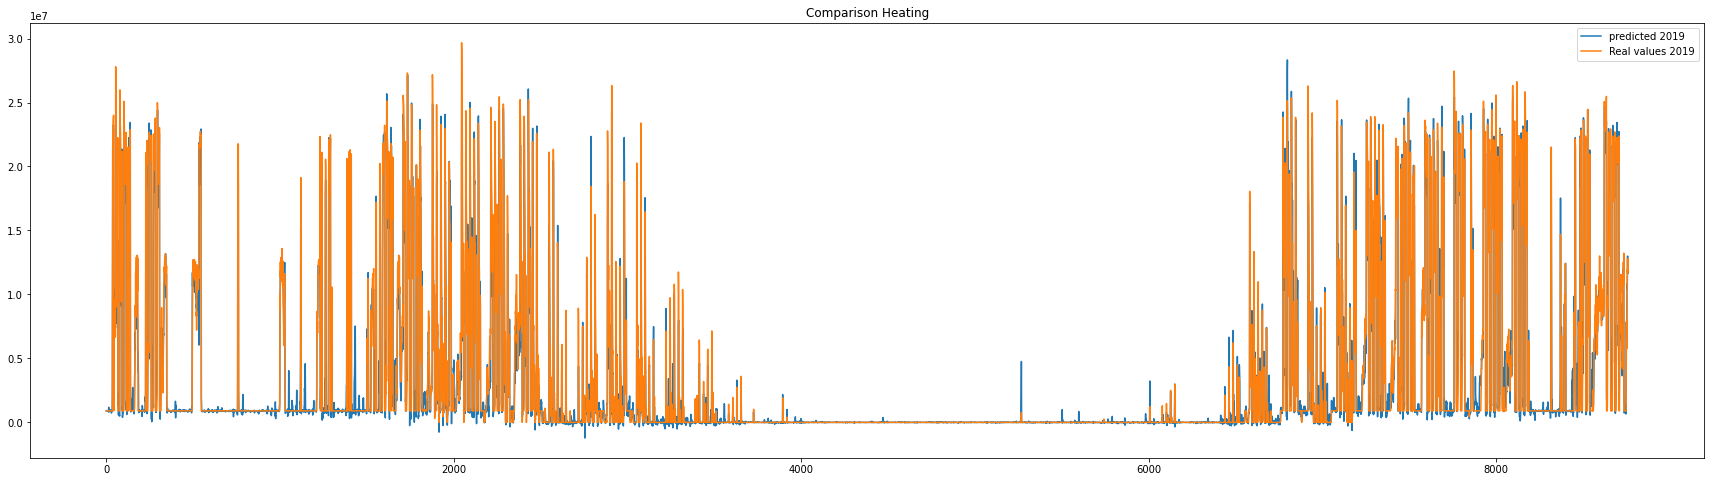

In [16]:
plt.figure(figsize=(30,8));

x_ax = range ( len(preds3))
plt.plot(x_ax,preds3, label ="predicted 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

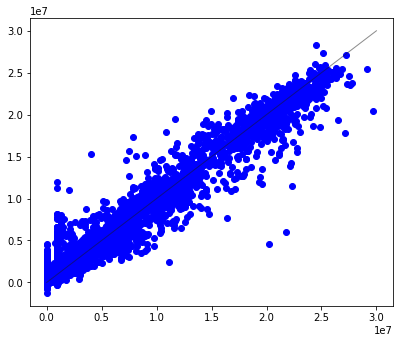

In [17]:
plt.figure(figsize=(6.5,5.3));
plt.plot(C,preds3,'bo');

plt.plot([0,3e7],[0,3e7],'-',color=[0.1,0.1,0.1,0.5],linewidth=1)

Lets find Accuracy of the model in mins and maxes

In doe file the threshold of heating is 15 degC



In [53]:
Max = test_targets.to_frame(name ='Heating')

In [54]:
test_inputs.sort_values(by="Dry Bulb Temperature")

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Speed,Total Sky Cover,Opaque Sky Cover,People Total Heating Energy,Total Zone Infiltration Sensible Heat Gain Energy,Averge Zones temp,ATTIC:Zone Air Temperature
79544,-34.8,-39.4,63.0,99880.0,130.311176,49,0.0,0.0,7,4,6,2.0,1,6,13311971.0,1987093.0,13.46564,-36.52920
79540,-34.4,-39.3,62.0,99910.0,131.252914,0,0.0,0.0,0,0,0,4.0,1,6,0.0,1873661.0,11.91809,-36.06500
79542,-34.4,-39.0,63.0,99880.0,131.445421,0,0.0,0.0,0,0,0,4.0,8,6,1464317.0,2216035.0,12.53789,-36.43160
79543,-34.4,-39.0,63.0,99860.0,131.445421,0,0.0,0.0,0,0,0,4.0,6,6,2795514.0,2187447.0,11.98644,-36.48760
79541,-34.2,-38.9,63.0,99900.0,131.951028,0,0.0,0.0,0,0,0,3.0,7,6,0.0,2103799.0,11.98183,-36.29190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82622,34.0,10.9,25.0,97290.0,439.761467,858,151.0,406.0,92,93,16,13.0,4,6,13311971.0,1974027.0,23.89069,49.27203
82621,34.1,10.8,24.0,97340.0,445.320963,949,388.0,364.0,102,95,16,15.0,6,7,11559291.0,1813380.0,23.99946,49.82594
82625,34.2,9.6,22.0,97260.0,431.885831,371,0.0,49.0,40,67,14,16.0,3,4,1464317.0,1689108.0,26.33504,40.80136
82624,35.2,9.1,20.0,97220.0,449.196556,556,218.0,288.0,60,83,13,14.0,0,7,4259831.0,7300978.0,23.88931,44.64788


In [66]:
## Extract their index
# saving indexes in a new column named index
index = test_inputs.index
condition = test_inputs['Dry Bulb Temperature']  <-30 
indices = index[condition]
indices_list = indices.tolist()
print(indices_list)

[79300, 79301, 79302, 79303, 79304, 79305, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568]


In [67]:
Max_input = test_inputs.loc[[79300, 79301, 79302, 79303, 79304, 79305, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568],:]

In [68]:
Max_Target= Max.loc[[79300, 79301, 79302, 79303, 79304, 79305, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568],:]

In [71]:
Max_Target.head(10)

,Heating
79300,900000.0
79301,900000.0
79302,900000.0
79303,900000.0
79304,900000.0
79305,900000.0
79516,900000.0
79517,900000.0
79518,900000.0
79519,900000.0


Fitting the model on Max

In [69]:
predsMax = model.predict(Max_input)

In [70]:
predsMax

array([853337.4 , 967823.44, 836495.94, 914972.25, 851591.06, 881651.06,
       934914.44, 991805.3 , 965948.1 , 979279.9 , 993734.6 , 948477.94,
       943822.8 , 903082.5 , 904196.94, 904254.5 , 904230.1 , 933239.  ,
       942685.5 , 893048.1 , 940501.6 , 939440.7 , 903452.4 , 904355.7 ,
       884726.94, 891227.5 , 886704.4 , 895157.4 , 885958.56, 929746.6 ,
       890758.  , 891396.9 , 883793.8 , 854887.4 , 896302.6 , 933737.75,
       856725.6 , 853458.94, 913702.6 , 822738.1 , 898414.6 , 854929.9 ,
       793367.1 , 876369.4 , 912155.5 , 931459.75, 959941.2 , 912252.56,
       909183.8 , 966678.06, 895383.  , 894409.2 , 894566.2 , 880504.56,
       890470.94], dtype=float32)

In [65]:
R2_score_Max=r2_score(Max_Target, predsMax)
print(R2_score_Max)

0.0


Predicting energy in 2019 using the Tyoical Weater data file

automatic outlier detection
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

Predicting energy in 2019 using the data of 2018 and comparing with real values in 2019

In [ ]:
R2_score1=r2_score(test_targets, preds3)
print(R2_score1)

0.9661309392454597


In [ ]:
Heating = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using data belobged to 2019'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

,predicted for Heating 2019 using data belobged to 2019,Heating Real Values
0,9.046932e+05,900000.0
1,9.092231e+05,900000.0
2,8.928031e+05,900000.0
3,9.037528e+05,900000.0
4,9.021367e+05,900000.0
...,...,...
8755,1.145935e+07,11735676.0
8756,1.299496e+07,12807904.0
8757,1.184588e+07,11698992.0
8758,1.165276e+07,12792717.0


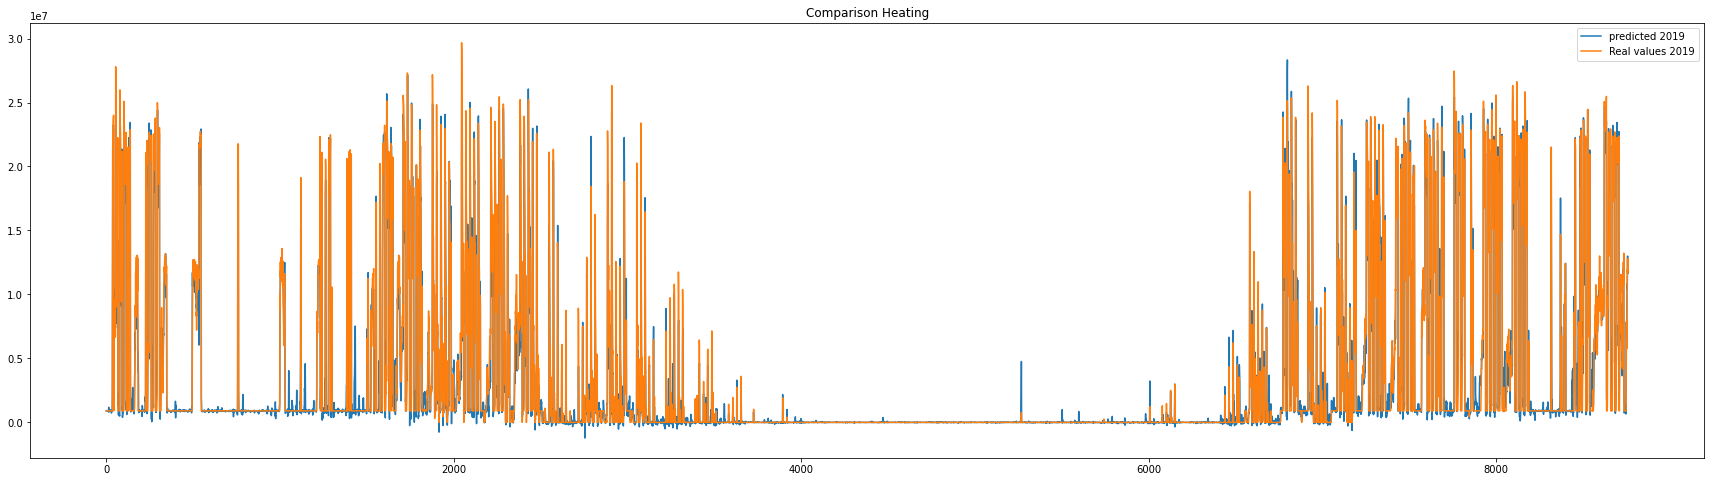

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(preds3))
plt.plot(x_ax,preds3, label ="predicted 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

Predicting energy in 2019 using the data of TW and comparing with real values in 2019

In [ ]:
Heating = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

In [ ]:
R2_score=r2_score(test_targets, preds3)
R2_score

In [ ]:
#Heating = pd.DataFrame(preds3, columns =['Heating 2019 '])
#Heating['Heating via TMY'] = pd.DataFrame(preds4)
#Heating.to_csv('Heating.csv')
#Heating

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
TMY_df3['Heating'][246]

In [ ]:
TMY_df3.loc[108:113]

In [ ]:
new_input = {'Dry Bulb Temperature': -24.5,
             'Dew Point Temperature': -28.4,
             'Relative Humidity': 70,
             'Atmospheric Pressure': 100480,
             'Extraterrestrial Horizontal Radiation': 0,
             'Extraterrestrial Direct Normal Radiation': 9999,
             'Horizontal Infrared Radiation Intensity from Sky': 166,
             'Global Horizontal Radiation': 0,
             'Direct Normal Radiation': 0,
             'Diffuse Horizontal Radiation': 0,
             'Global Horizontal Illuminance': 0,
             'Direct Normal Illuminance': 0,
             'Diffuse Horizontal Illuminance':0,
             'Zenith Luminance': 9999,
             'Wind Direction': 20,
             'Wind Speed': 6,
             'Total Sky Cover': 0,
             'Opaque Sky Cover': 8,
             'Visibility': 999,
             'Ceiling Height': 99990,
             'Present Weather Observation':9,
             'Precipitable Water': 0,
             'Aerosol Optical Depth':0 ,
             'Snow Depth' : 0,
             'Days Since Last Snow': 88,
             'Albedo' : 999,
             'Liquid Precipitation Depth' :999 ,
             'Liquid Precipitation Quantity' : 99,
             'People Total Heating Energy' :0 ,
             'Total Zone Infiltration Sensible Heat Gain Energy' : 893710,
             'Averge Zones temp': 14.66877,
             'ATTIC:Zone Air Temperature' : -24,
             
              }

In [ ]:
new_input_df = pd.DataFrame([new_input])
new_input_df.info()

In [ ]:
prediction = model.predict(new_input_df)
prediction

# Gas HVAC

In [ ]:
############# Light Electricity (j) ############# 
#electricity
raw_df1=raw_df.drop(raw_df.columns[[1,35,36,37,38]], axis=1)

## Typical weather data file ( all parts of energy consumption)
#electricity
TMY_df1=TMY_df.drop(TMY_df.columns[[1,35,36,37,38]], axis=1)

##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df1.Date).dt.year

train_df = raw_df1[year < 2017]
val_df = raw_df1[year == 2017]
test_df = raw_df1[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'LightsElectricity'
## specifying input an target in Typical weather data file
input_cols_TMY1 = (TMY_df1.columns)[1:-1]
target_col_TMY1 = 'LightsElectricity'

## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df1[input_cols_TMY1].copy()
test_targets_TMY = TMY_df1[target_col_TMY1].copy()

# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data

model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

In [ ]:
A =pd.DataFrame(test_df[target_col]) 

A.reset_index(inplace = True)
A.drop('index', axis=1, inplace=True)
A

In [ ]:
LightsElectricity = pd.DataFrame(preds4, columns =['predicted for LightsElectricity2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
LightsElectricity[' LightsElectricity Real Values'] = A 
raw_df.to_csv('LightsElectricity.csv')
LightsElectricity

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="Predicted for 2019 using TMY")
#plt.plot(x_ax,preds3, label = "Predicted for 2019 using data of 2019")
plt.plot(x_ax,A, label = "Real Value ")
plt.title("Comparison Lights Electricity")
plt.legend()
plt.show()


In [ ]:
############# Defining Scenarios ############# 
## Actua weather data file (all parts of energy consumption)

#cooling : [[34,36,37,38]]
raw_df2=raw_df.drop(raw_df.columns[[1,34,36,37,38]], axis=1)

#cooling : [[34,36,37,38]]
TMY_df2=TMY_df.drop(TMY_df.columns[[1,34,36,37,38]], axis=1)


##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df2.Date).dt.year

train_df = raw_df2[year < 2017]
val_df = raw_df2[year == 2017]
test_df = raw_df2[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'Cooling'
## specifying input an target in Typical weather data file
input_cols_TMY2 = (TMY_df2.columns)[1:-1]
target_col_TMY2 = 'Cooling'


## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df2[input_cols_TMY2].copy()
test_targets_TMY = TMY_df2[target_col_TMY2].copy()



# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data
model.fit(train_inputs, train_targets)
preds = model.predict(train_inputs)


model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

In [ ]:
B=pd.DataFrame(test_df[target_col]) 

B.reset_index(inplace = True)
B.drop('index', axis=1, inplace=True)
B

In [ ]:
cooling = pd.DataFrame(preds4, columns =['predicted for cooling 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
cooling[' cooling Real Values'] = B 
raw_df.to_csv('cooling.csv')
cooling

In [ ]:
#cooling = pd.DataFrame(preds3, columns =['coolingvia2019 '])
#cooling['cooling via TMY'] = pd.DataFrame(preds4)
#cooling[' cooling Real Values'] = B
#raw_df.to_csv('cooling.csv')
#cooling

In [ ]:
#coolingvia2019 = pd.DataFrame(preds3, columns =['energy via 2019'])
#coolingvia2019['energy via TMY'] = pd.DataFrame(preds4)

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,B, label = "Real values 2019")
plt.title("Comparison Cooling")
plt.legend()
plt.show()

In [ ]:
C=pd.DataFrame(test_df[target_col]) 

C.reset_index(inplace = True)
C.drop('index', axis=1, inplace=True)
C

In [ ]:
Heating = pd.DataFrame(preds4, columns =['predicted for Heating 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

In [ ]:
#Heating = pd.DataFrame(preds3, columns =['Heating 2019 '])
#Heating['Heating via TMY'] = pd.DataFrame(preds4)
#Heating.to_csv('Heating.csv')
#Heating

In [ ]:
plt.figure(figsize=(15,8));

x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
TMY_df3['Heating'][246]

In [ ]:
TMY_df3.loc[108:113]

In [ ]:
from IPython.display import display
with pd.option_context('display.max_rows', 50):
    display(TMY_df3[TMY_df3.Heating > 1000]);

In [ ]:
new_input = {'Dry Bulb Temperature': -24.5,
             'Dew Point Temperature': -28.4,
             'Relative Humidity': 70,
             'Atmospheric Pressure': 100480,
             'Extraterrestrial Horizontal Radiation': 0,
             'Extraterrestrial Direct Normal Radiation': 9999,
             'Horizontal Infrared Radiation Intensity from Sky': 166,
             'Global Horizontal Radiation': 0,
             'Direct Normal Radiation': 0,
             'Diffuse Horizontal Radiation': 0,
             'Global Horizontal Illuminance': 0,
             'Direct Normal Illuminance': 0,
             'Diffuse Horizontal Illuminance':0,
             'Zenith Luminance': 9999,
             'Wind Direction': 20,
             'Wind Speed': 6,
             'Total Sky Cover': 0,
             'Opaque Sky Cover': 8,
             'Visibility': 999,
             'Ceiling Height': 99990,
             'Present Weather Observation':9,
             'Precipitable Water': 0,
             'Aerosol Optical Depth':0 ,
             'Snow Depth' : 0,
             'Days Since Last Snow': 88,
             'Albedo' : 999,
             'Liquid Precipitation Depth' :999 ,
             'Liquid Precipitation Quantity' : 99,
             'People Total Heating Energy' :0 ,
             'Total Zone Infiltration Sensible Heat Gain Energy' : 893710,
             'Averge Zones temp': 14.66877,
             'ATTIC:Zone Air Temperature' : -24,
             
              }

In [ ]:
new_input_df = pd.DataFrame([new_input])
new_input_df.info()

In [ ]:
prediction = model.predict(new_input_df)
prediction